## 1. Generating Random Networks
***

### Packages
***

In [1]:
library(igraph)
library(resample)
library(textTinyR)
library(Matrix)
library(pracma)


載入套件：‘igraph’


下列物件被遮斷自 ‘package:stats’:

    decompose, spectrum


下列物件被遮斷自 ‘package:base’:

    union


載入需要的套件：Matrix


載入套件：‘pracma’


下列物件被遮斷自 ‘package:Matrix’:

    expm, lu, tril, triu




### 1. Create random networks using Erd ̈os-R ́enyi (ER) model
***

#### (a) Create undirected random networks with n = 900 nodes, and the probability p for drawing an edge between two arbitrary vertices 0.002, 0.006, 0.012, 0.045, and 0.1. Plot the degree distributions. What distribution (linear/exponential/gaussian/binomial or something else) is observed? Explain why. Also, report the mean and variance of the degree distributions and compare them to the theoretical values.

> Ans: We observed that they are binomial distributions. The reason is that for each vertice the ER model will randomly determine if a edge should be kept with a probability of $p$ between all other $n-1$ vertices. Therefore, the number of edges of a vertice, i.e. degree, should follow binomial distribution with mean $(n-1)p$ and variance $(n-1)p(1-p)$. Also, as we can see in the below cell, the experimental results are close to the theoretical values.

p=0.002: mean=1.851; variance=1.735
theoretical: mean=1.798; variance=1.794

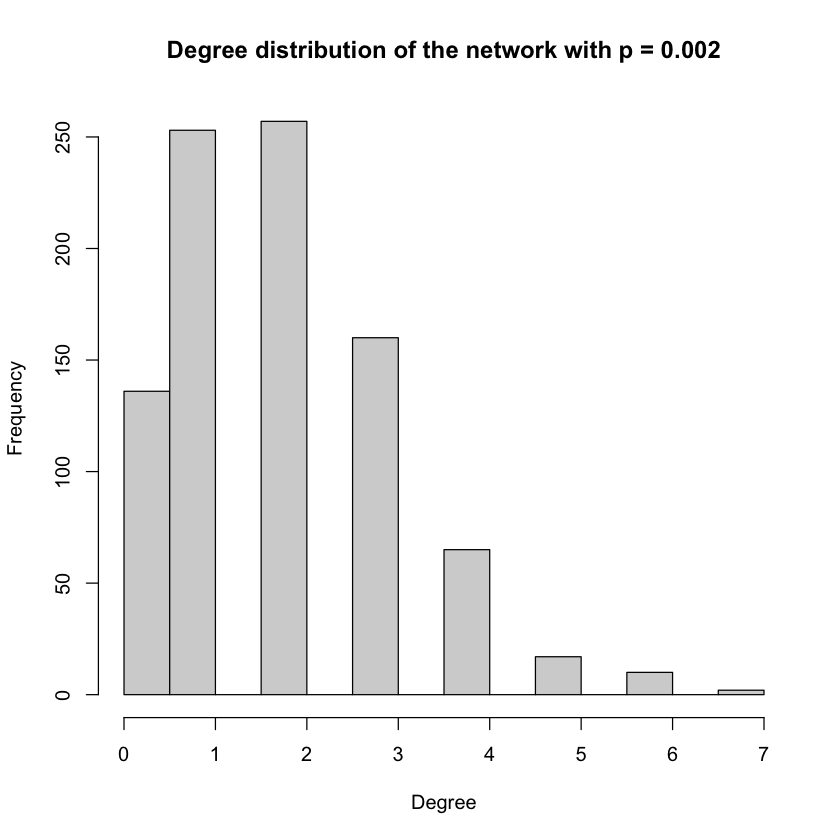

p=0.006: mean=5.349; variance=5.487
theoretical: mean=5.394; variance=5.362

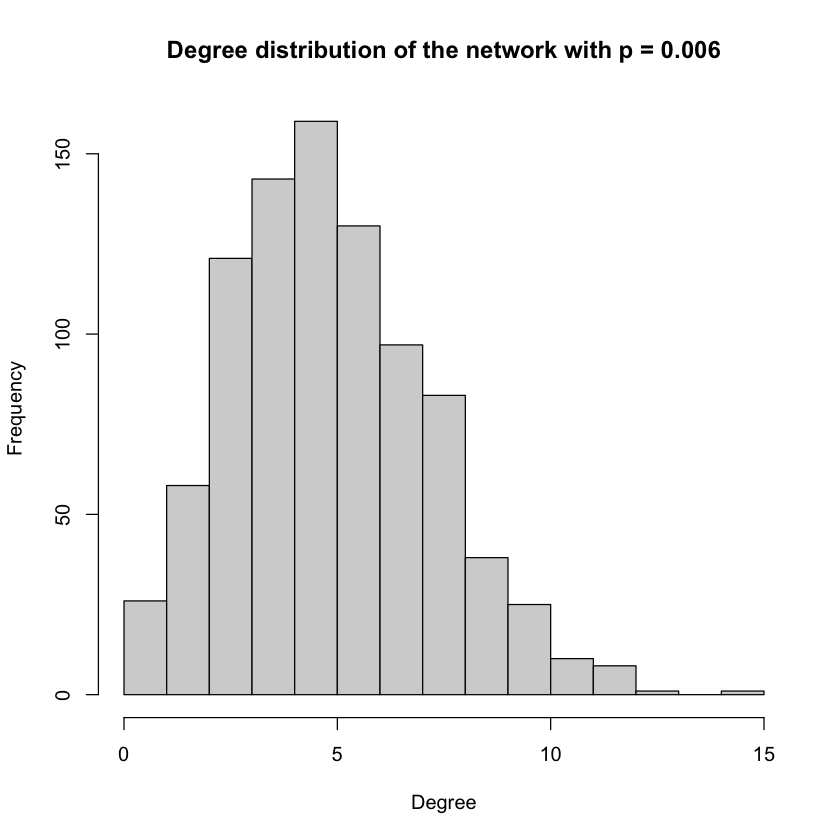

p=0.012: mean=10.991; variance=11.682
theoretical: mean=10.788; variance=10.659

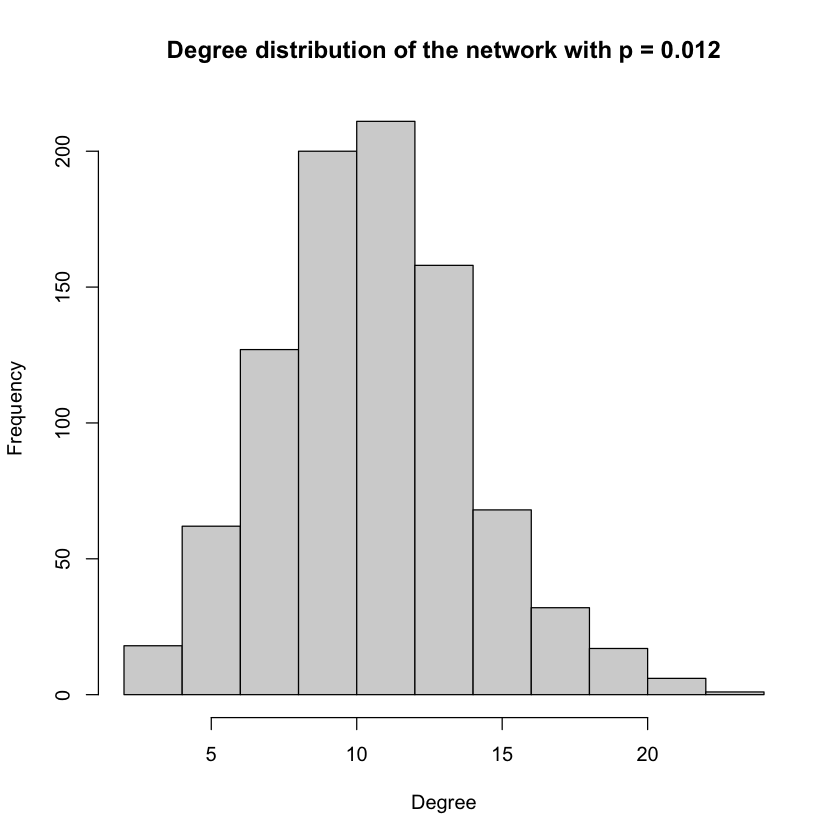

p=0.045: mean=40.698; variance=38.485
theoretical: mean=40.455; variance=38.635

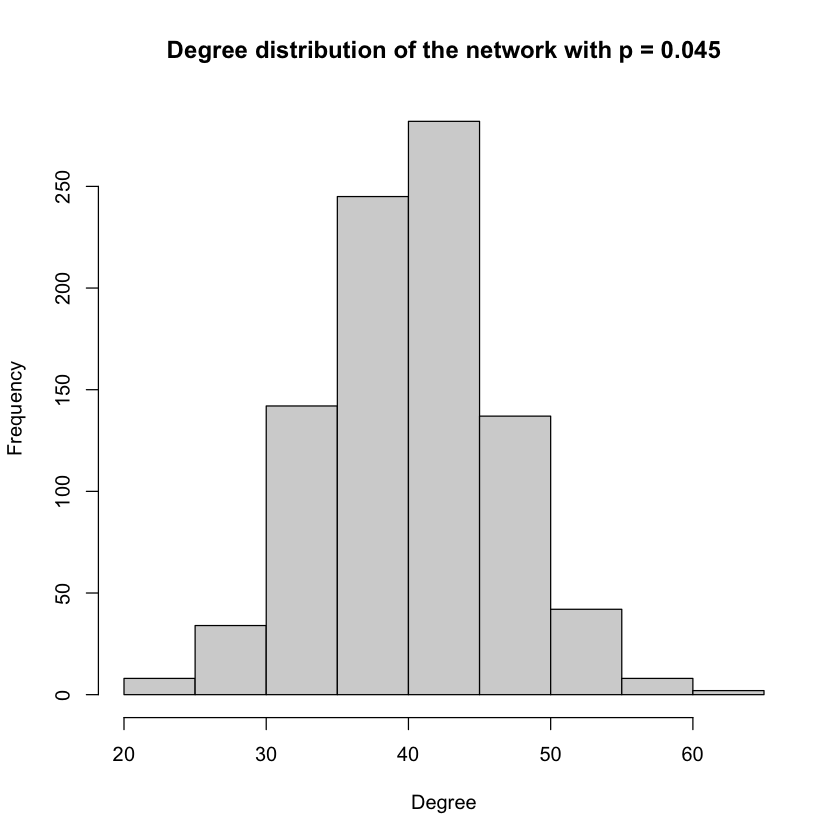

p=0.100: mean=89.493; variance=77.516
theoretical: mean=89.900; variance=80.910

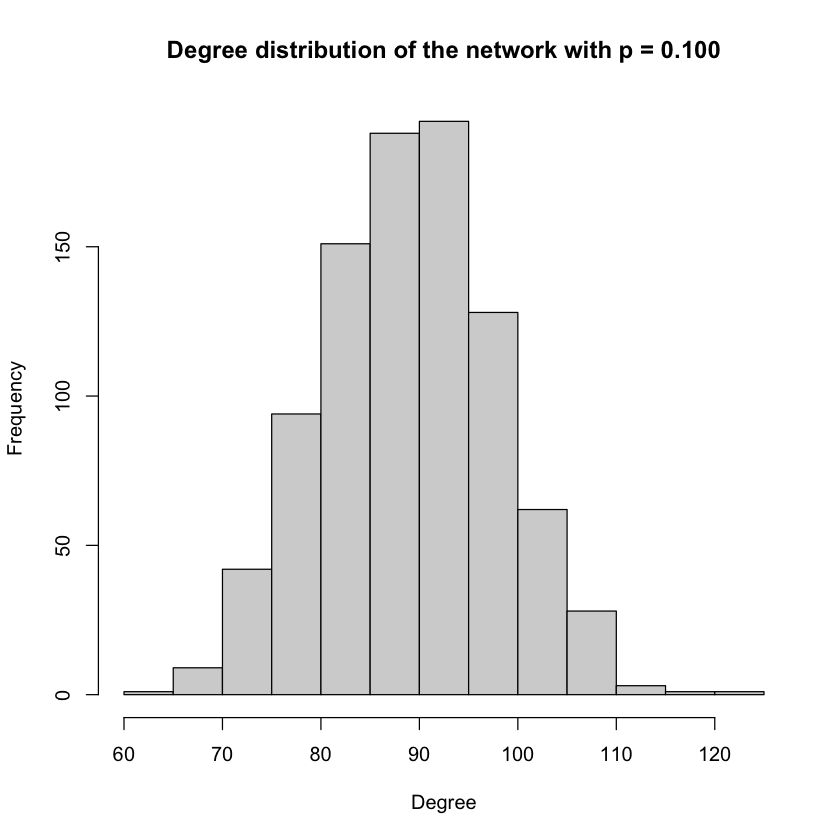

In [2]:
n <- 900
ps <- c(0.002, 0.006, 0.012, 0.045, 0.1)

for (p in ps) {
    g <- sample_gnp(n, p, directed=FALSE)
    hist(
        degree(g),
        main=sprintf("Degree distribution of the network with p = %0.3f", p),
        xlab="Degree",
        ylab="Frequency",
    )
    fprintf("p=%.3f: mean=%.3f; variance=%.3f\n", p, mean(degree(g)), var(degree(g)))
    fprintf("theoretical: mean=%.3f; variance=%.3f", (n - 1) * p, (n - 1) * p * (1 - p))
}

#### (b) For each p and n = 900, answer the following questions: Are all random realizations of the ER network connected? Numerically estimate the probability that a generated network is connected. For one instance of the networks with that p, find the giant connected component (GCC) if not connected. What is the diameter of the GCC?

> Ans: No, not all ER networks are connected, and the numerically-estimated probabilities are calculated in the below cell. In addition, the diameters of GCCs from non-connected network are also shown in the below cell.

In [3]:
n <- 900
n_trail <- 1000

for (p in ps) {
    gcc_is_found <- FALSE
    connected_count <- 0
    diameter_gcc <- NULL

    for (i in 1:n_trail) {
        g <- sample_gnp(n ,p , directed=FALSE)
        if (is.connected(g)) {
            connected_count <- connected_count + 1
        }
        else if (!is.connected(g) & !gcc_is_found) {
            g.components <- clusters(g)
            max_size <- which.max(g.components$csize)
            g.giant <- induced.subgraph(g, which(g.components$membership == max_size))
            diameter_gcc <- diameter(g.giant, directed=FALSE)
            gcc_is_found <- TRUE
        }
    }
    fprintf("Probability that a generated network is connected for p = %0.3f: %.3f.\n", p, connected_count/n_trail)
    
    if (is.null(diameter_gcc)) {
        fprintf("All generated networks are connected.\n\n")
    }
    else {
        fprintf("Diameter of GCC for a non-connected network: %d.\n\n", diameter_gcc)
    }
}

Probability that a generated network is connected for p = 0.002: 0.000.
Diameter of GCC for a non-connected network: 24.

Probability that a generated network is connected for p = 0.006: 0.027.
Diameter of GCC for a non-connected network: 9.

Probability that a generated network is connected for p = 0.012: 0.978.
Diameter of GCC for a non-connected network: 5.

Probability that a generated network is connected for p = 0.045: 1.000.
All generated networks are connected.

Probability that a generated network is connected for p = 0.100: 1.000.
All generated networks are connected.



#### (c) It turns out that the normalized GCC size (i.e., the size of the GCC as a fraction of the total network size) is a highly nonlinear function of p, with interesting properties occurring for values where p = O( 1/n ) and p = O(ln n/n ). For n = 900, sweep over values of p from 0 to a pmax that makes the network almost surely connected and create 100 random networks for each p. pmax should be roughly determined by yourself. Then scatter plot the normalized GCC sizes vs p. Plot a line of the average normalized GCC sizes for each p along with the scatter plot.

+ i. Empirically estimate the value of p where a giant connected component starts to emerge (define your criterion of “emergence”)? Do they match with theoretical values mentioned or derived in lectures?

> Ans: We define the emergence criterion to be the normalized GCC size of 0.1 (Ref: http://networksciencebook.com/chapter/3#evolution-network). The experiment shows that it starts to emerge when p=0.0012, which matches the theoretical value $1/900=0.0011$

+ ii. Empirically estimate the value of p where the giant connected component takes up over 99% of the nodes in almost every experiment.

> Ans: The empirically-estimated value of p is 0.0086.

In [4]:
n <- 900
p_max <- 0.012
ps <- seq(0, p_max, 0.0001)
n_trail <- 100
gcc_sizes <- matrix(data=0.0, nrow=length(ps), ncol=n_trail)
avg_gcc_sizes <- matrix(data=0.0, nrow=length(ps), ncol=1)

for (i in 1:length(ps)){
    for (j in 1:n_trail){
        g <- sample_gnp(n, ps[i], directed=FALSE)
        g.components <- clusters(g)
        gcc_sizes[i, j] <- max(g.components$csize) / n   
    }
    avg_gcc_sizes[i] <- mean(gcc_sizes[i,])
}

The value of p where a giant connected component starts to emerge: 0.0012
The value of p where the giant connected component takes up over 99 percent of the nodes: 0.0086

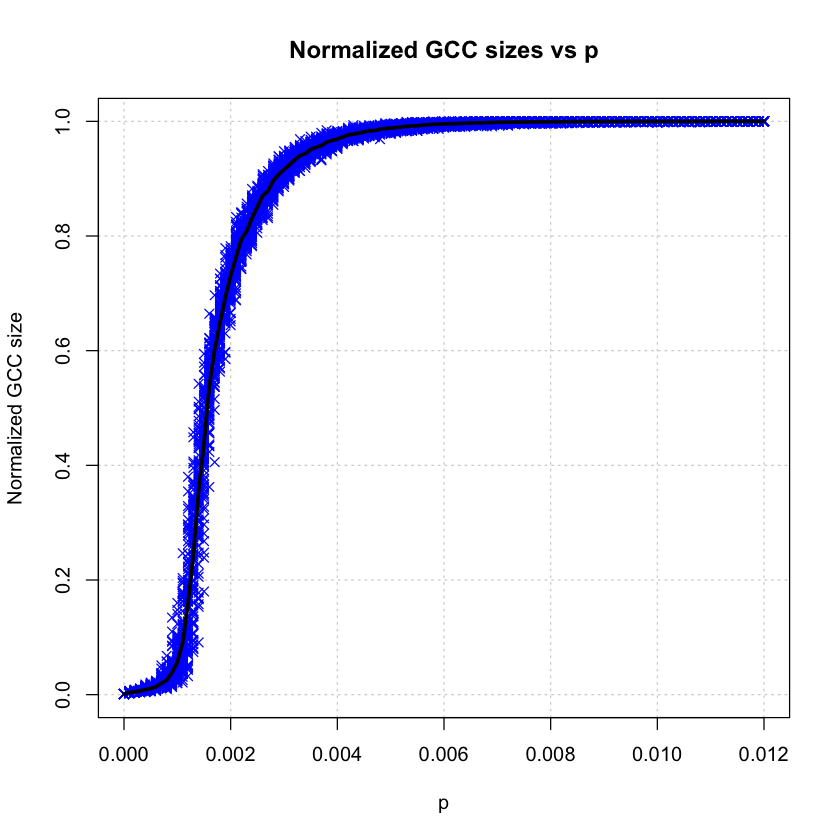

In [5]:
plot(
    rep(ps[1], n_trail),
    gcc_sizes[1, 1:n_trail],
    xlim=c(0, p_max),
    ylim=c(0, 1),
    xlab="p",
    main="Normalized GCC sizes vs p",
    ylab="Normalized GCC size",
    grid(),
    pch=4,
    col="blue",
)

for (j in 2:length(ps)) {
    points(rep(ps[j], n_trail), gcc_sizes[j, 1:n_trail], pch=4, col="blue")
}

lines(ps, avg_gcc_sizes, lwd=3)

fprintf("The value of p where a giant connected component starts to emerge: %.4f\n", ps[min(which(avg_gcc_sizes > 0.1))])
fprintf("The value of p where the giant connected component takes up over 99 percent of the nodes: %.4f", ps[mean(which(avg_gcc_sizes>0.99))])


#### (d)
+ i. Define the average degree of nodes c = n × p = 0.5. Sweep over the number of nodes, n, ranging from 100 to 10000. Plot the expected size of the GCC of ER networks with n nodes and edge-formation probabilities p = c/n, as a function of n. What trend is observed?

> Ans: We observed that the trend is $O(\ln n)$.

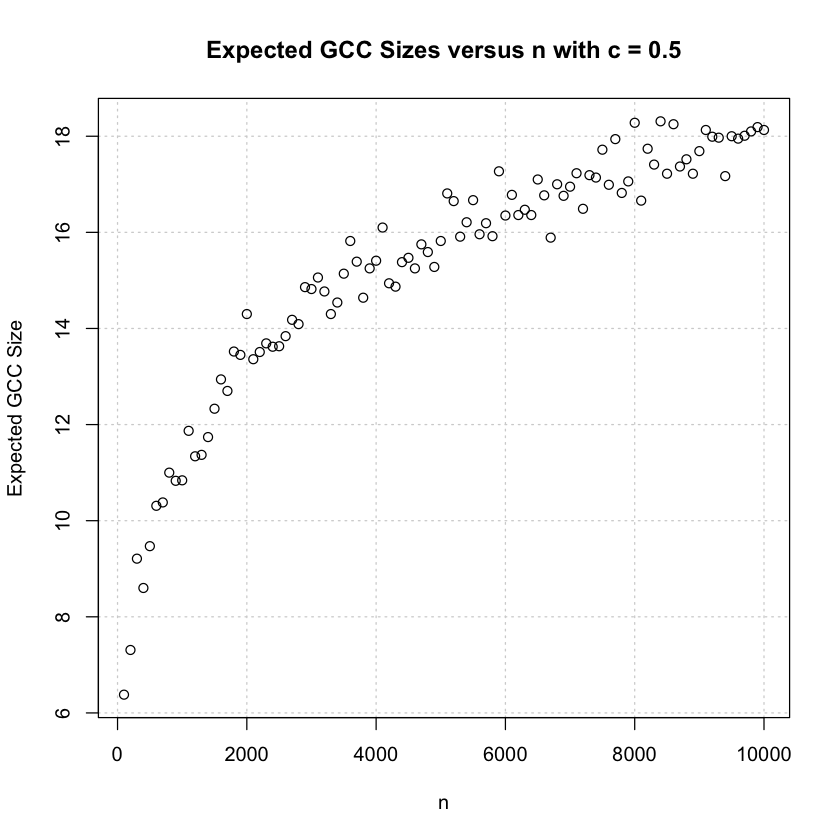

In [6]:
get_expected_gcc_sizes <- function(ns, c, n_trail=100, directed=FALSE) {
    gcc_sizes <- matrix(data=0.0, nrow=length(ns), ncol=n_trail)
    avg_gcc_sizes = matrix(data=0.0, nrow=length(ns), ncol=1)

    for (i in 1:length(ns)){
        for (j in 1:n_trail){
            g <- sample_gnp(ns[i], c / ns[i], directed=directed)
            g.components <- clusters(g)
            gcc_sizes[i, j] <- max(g.components$csize)  
        }
        avg_gcc_sizes[i] <- mean(gcc_sizes[i,])
    }
    
    return (avg_gcc_sizes)
}


ns <- seq(100, 10000, 100)
avg_gcc_sizes <- get_expected_gcc_sizes(ns, c=0.5)
plot(
    ns,
    avg_gcc_sizes,
    main="Expected GCC Sizes versus n with c = 0.5",
    xlab="n",
    ylab="Expected GCC Size",
    grid(),
)

+ ii. Repeat the same for c = 1.

> Ans: We observed that the trend is $O(n^{2/3})$.

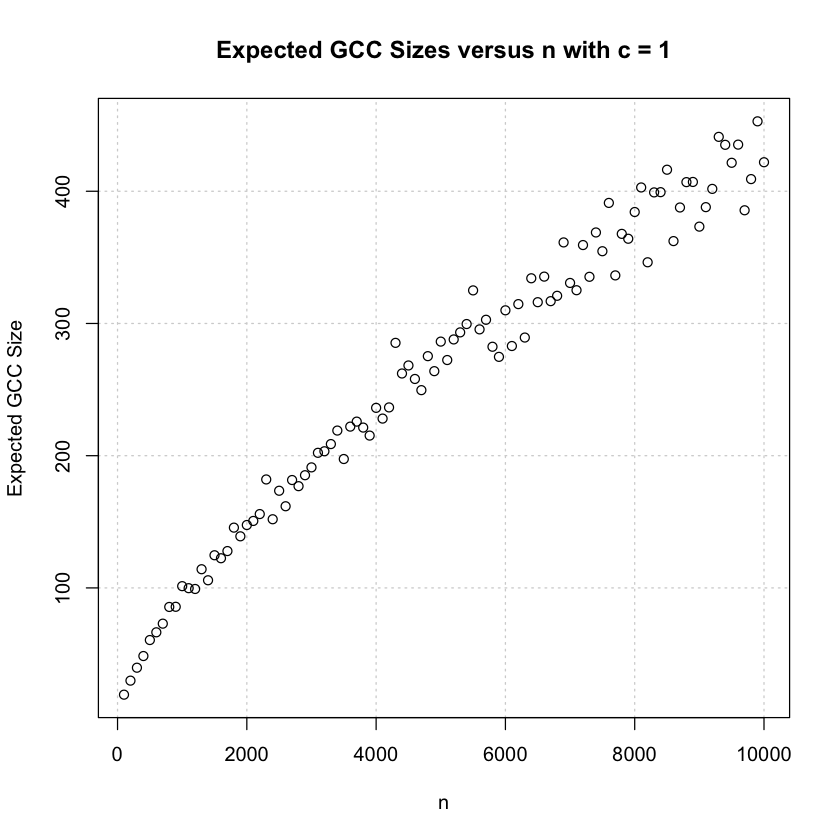

In [7]:
avg_gcc_sizes <- get_expected_gcc_sizes(ns, c=1)
plot(
    ns,
    avg_gcc_sizes,
    main="Expected GCC Sizes versus n with c = 1",
    xlab="n",
    ylab="Expected GCC Size",
    grid(),
)

+ iii. Repeat the same for values of c = 1.15, 1.25, 1.35, and show the results for these three values in a single plot.

> Ans: We observed that the trends are all $O(n)$.

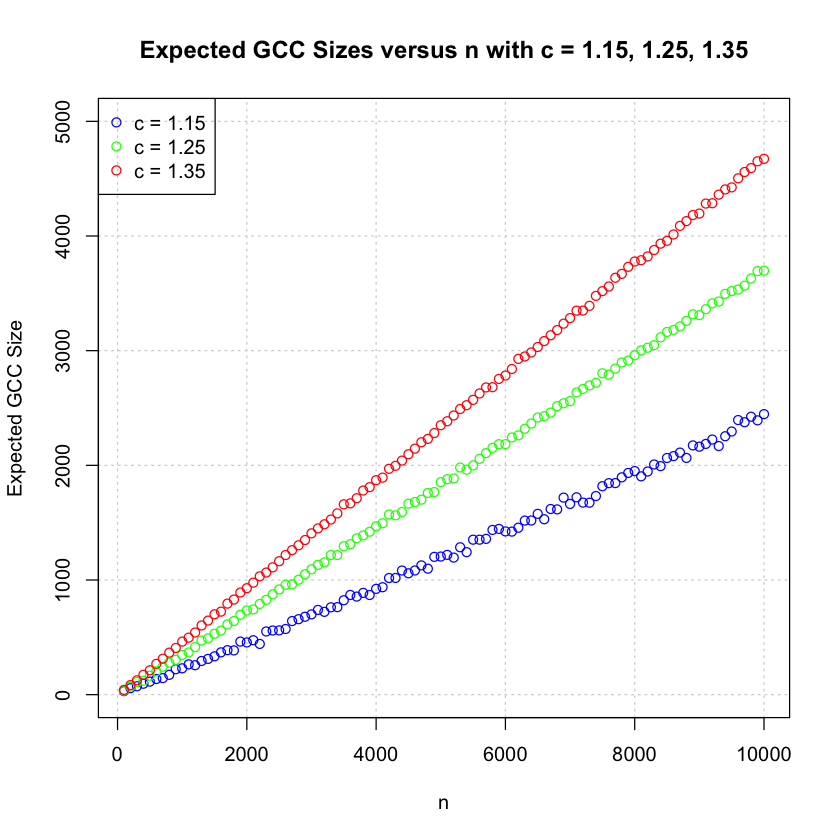

In [8]:
avg_gcc_sizes <- get_expected_gcc_sizes(ns, c=1.15)
plot(
    ns,
    avg_gcc_sizes,
    main="Expected GCC Sizes versus n with c = 1.15, 1.25, 1.35",
    xlab="n",
    ylab="Expected GCC Size",
    grid(),
    col="blue",
    ylim=c(0, 5000),
)

avg_gcc_sizes <- get_expected_gcc_sizes(ns, c=1.25)
points(ns, avg_gcc_sizes, col="green")

avg_gcc_sizes <- get_expected_gcc_sizes(ns, c=1.35)
points(ns, avg_gcc_sizes, col="red")

legend(
    "topleft",
    legend=c("c = 1.15", "c = 1.25", "c = 1.35"),
    pch=c(1, 1, 1),
    col=c("blue", "green", "red"),
)

+ iv. What is the relation between the expected GCC size and n in each case?

> Ans: When $c<1$, the expected GCC size is $O(\ln n)$. While when $c=1$, it becomes $O(n^{2/3})$. Finally when $c>1$, the expected GCC size is linear to n. In addition, the slope increases as c increases.

> Ref: https://www.cs.cmu.edu/~avrim/598/chap4only.pdf

### 2. Create networks using preferential attachment model
***

#### (a) Create an undirected network with n = 1050 nodes, with preferential attachment model, where each new node attaches to m = 1 old nodes. Is such a network always connected?

> Ans: Yes, a preferential attachment model is supposed to always connected. And the experiment results also show a connected probability of 100%.

In [9]:
check_preferential_connectness <- function(m, n, n_trail=100) {
    connected_count = 0
    for (i in 1:n_trail) {
        g <- barabasi.game(n, m=m, directed=FALSE)
        if (is.connected(g)) {
            connected_count <- connected_count + 1
        }
    }
    fprintf("Connected rate with m = %d and n = %d: %.2f\n", m, n, connected_count / n_trail)
}


check_preferential_connectness(m=1, n=1050)

Connected rate with m = 1 and n = 1050: 1.00


#### (b) Use fast greedy method to find the community structure. Measure modularity. Define Assortativity. Compute Assortativity.

> Ans: The modularity and assortativity scores are shown in the below cell. Assortativity measures the level of homophyly of the graph, based on some vertex labeling or values assigned to vertices. If the coefficient is high, that means that connected vertices tend to have the same labels or similar assigned values. Here we define assortativity for a undirected graph based on the **degree** of the vertice as: $score=\frac{1}{\sigma_q^2}\sum_{jk}jk(e_{jk}-q_jq_k)$.

> Ref: https://igraph.org/r/doc/assortativity.html

In [10]:
measure_scores <- function(m, n) {
    g <- barabasi.game(n, m=m, directed=FALSE)
    modularity_score <- modularity(cluster_fast_greedy(g))
    assortativity_score <- assortativity_degree(g, directed=FALSE)
    fprintf("m = %d, n = %d: ", m, n)
    fprintf("modularity = %.3f; assortativity = %.3f\n", modularity_score, assortativity_score)
}


measure_scores(m=1, n=1050)

m = 1, n = 1050: modularity = 0.936; assortativity = -0.094


#### (c) Try to generate a larger network with 10500 nodes using the same model. Compute modularity and assortativity. How is it compared to the smaller network’s modularity?

> Ans: Modularity increases from 0.936 to 0.978 because the number of nodes in smaller communities increases as n increases. It means that the sparsity of inter-community increases which will increase the modularity of the network.

In [11]:
measure_scores(m=1, n=10500)

m = 1, n = 10500: modularity = 0.978; assortativity = -0.020


#### (d) Plot the degree distribution in a log-log scale for both n = 1050, 10500, then estimate the slope of the plot using linear regression.

> Ans: The results are shown in the below cell.

Slope with m = 1 and n = 1050: -2.789

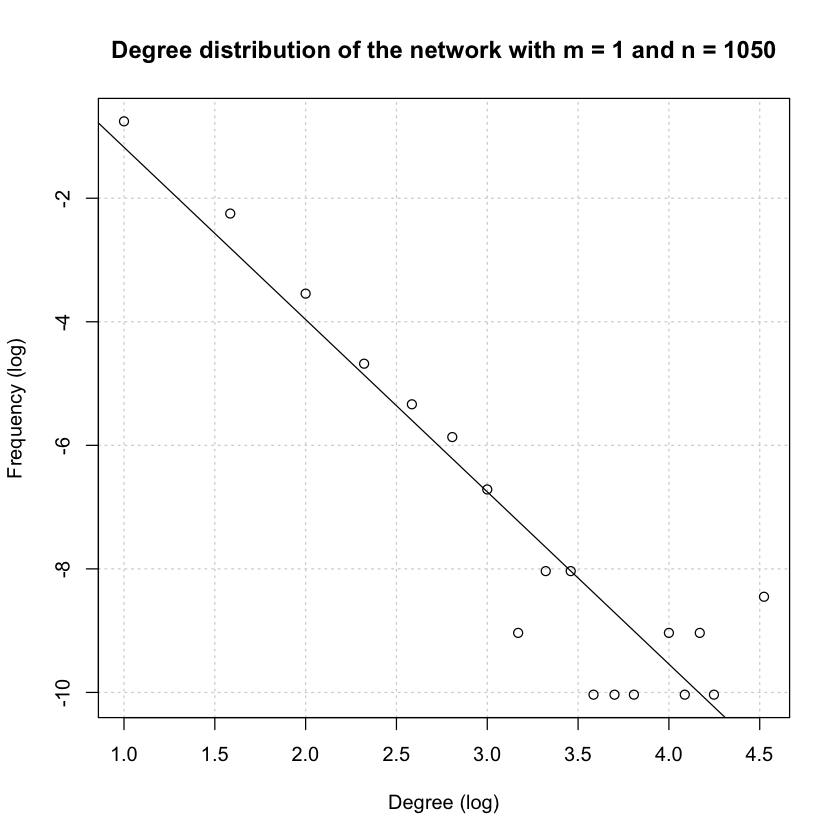

Slope with m = 1 and n = 10500: -2.882

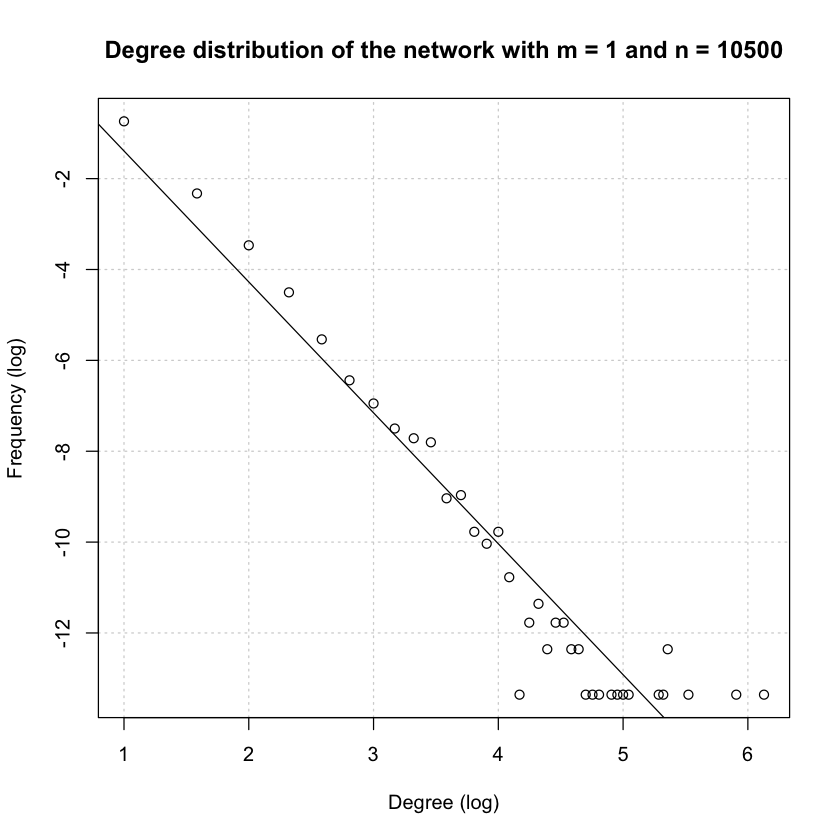

In [12]:
plot_degree_distribution <- function(m, n, g=NULL) {
    if (is.null(g)) {
        g <- barabasi.game(n, m=m, directed=FALSE)
    }
    deg_dist <- degree.distribution(g)
    non_zero_idxs <- which(deg_dist != 0, arr.ind=TRUE)
    x <- log2(c(1: length(deg_dist)))[non_zero_idxs]
    y <- log2(deg_dist)[non_zero_idxs]
    plot(
        x,
        y,
        main=sprintf("Degree distribution of the network with m = %d and n = %d", m, n),
        xlab="Degree (log)",
        ylab="Frequency (log)",
        grid(),
    )
    linear_model <- lm(y ~ x)
    abline(linear_model)
    fprintf("Slope with m = %d and n = %d: %.3f", m, n, coef(linear_model)[2])
}


plot_degree_distribution(m=1, n=1050)
plot_degree_distribution(m=1, n=10500)

#### (e) In the two networks generated in 2(a) and 2(c), perform the following: Randomly pick a node i, and then randomly pick a neighbor j of that node. Plot the degree distribution of nodes j that are picked with this process, in the log-log scale. Is the distribution linear in the log-log scale? If so, what is the slope? How does this differ from the node degree distribution?

> Ans: Yes, it is linear in the log-log scale and the slopes are shown in the below cell. The absolute value of the slopes are much smaller than those of the node degree distribution.

Slope with m = 1 and n = 1050: -0.936

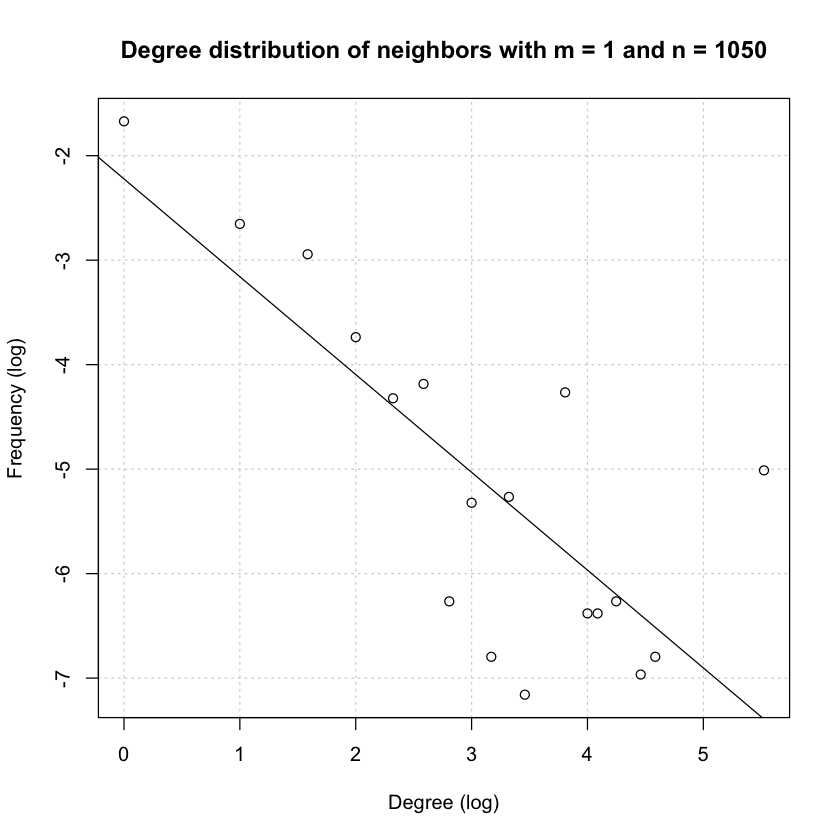

Slope with m = 1 and n = 10500: -1.342

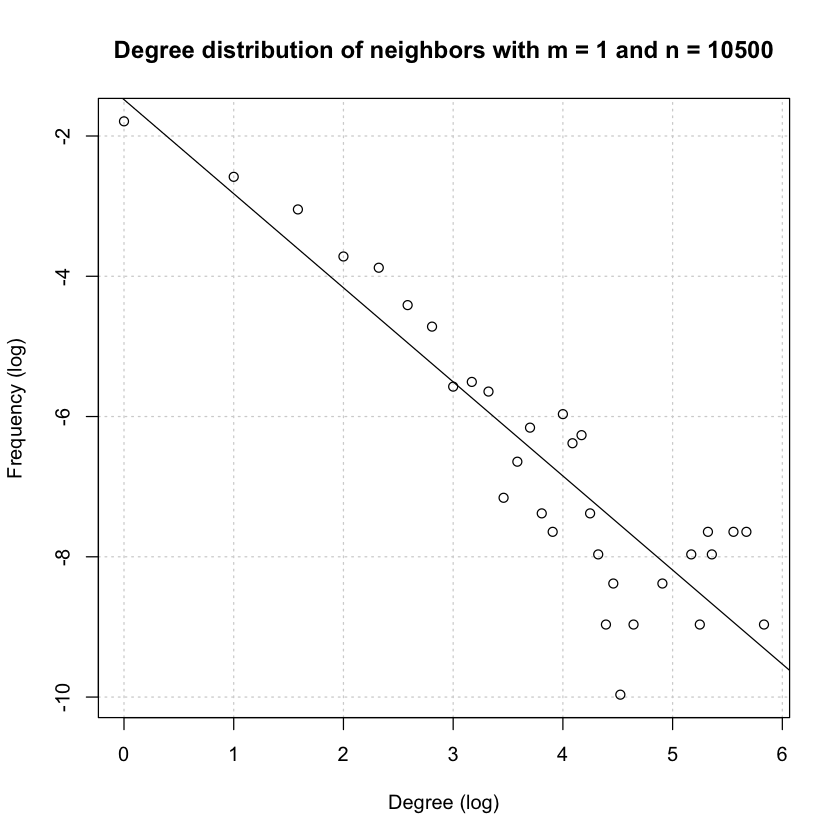

In [13]:
plot_neighbor_degree_distribution <- function(m, n, n_sample=1000) {
    g <- barabasi.game(n, m=m, directed=FALSE)
    degs <- matrix(data=0.0, nrow=n_sample, ncol=1)
    
    for (i in 1: n_sample) {
        sample_node <- sample(n, 1)
        neighs <- neighbors(g, sample_node)
        sample_neighbor <- sample(neighs, 1)
        degs[i, 1] <- degree(g, sample_neighbor) 
    }
    
    deg_dist <- table(degs)
    x <- log2(as.numeric(names(deg_dist)))
    y <- log2(as.vector(deg_dist) / n_sample)
    plot(
        x,
        y,
        main=sprintf("Degree distribution of neighbors with m = %d and n = %d", m, n),
        xlab="Degree (log)",
        ylab="Frequency (log)",
        grid(),
    )
    linear_model <- lm(y ~ x)
    abline(linear_model)
    fprintf("Slope with m = %d and n = %d: %.3f", m, n, coef(linear_model)[2])
}


plot_neighbor_degree_distribution(m=1, n=1050)
plot_neighbor_degree_distribution(m=1, n=10500)

#### (f) Estimate the expected degree of a node that is added at time step i for 1 ≤ i ≤ 1050. Show the relationship between the age of nodes and their expected degree through an appropriate plot. Note that the newest added node is the youngest.

> Ans: The result is shown in the below cell.

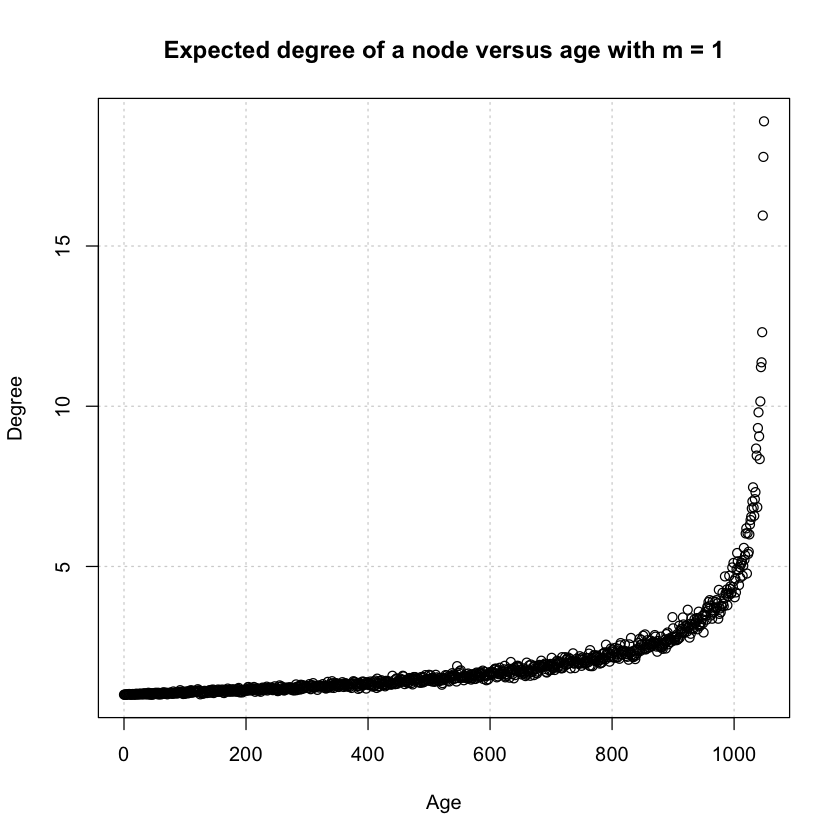

In [14]:
plot_age_degree_relation <- function(m, n=1050, n_trail=100) {
    ages = matrix(data=0.0, nrow=n, ncol=1)
    for (i in 1: n_trail) {
        g <- barabasi.game(n, m=m, directed=FALSE)
        ages <- ages + degree(g)
    }
    ages <- ages / n_trail
    plot(
        seq(n-1, 0, -1),
        ages,
        main=sprintf("Expected degree of a node versus age with m = %d", m),
        xlab="Age",
        ylab="Degree",
        grid(),
    )
}


plot_age_degree_relation(m=1)

#### (g) Repeat the previous parts (a-f) for m = 2, and m = 6. Compare the results of each part for different values of m.

> Ans:
> + a
    + all of them are connected.
> + b
    + Modularity decreases as m increases.
    + Assortativity becomes closer to 0 as m increases.
> + c
    + Modularity decreases as m increases, while it still increases as n increases with the same m.
    + Assortativity becomes closer to 0 as m increases.
> + d
    + The absolute value of the slopes decreases as m increases.
> + e
    + The absolute value of the slopes decreases as m increases.
    + The absolute value of the slopes of neighbor degree distribution are much smaller than those of the node degree distribution.
> + f
    + The trends are similar with different values of m.
    + Degree increases as m increases.

Connected rate with m = 2 and n = 1050: 1.00
m = 2, n = 1050: modularity = 0.526; assortativity = -0.029
m = 2, n = 10500: modularity = 0.530; assortativity = -0.008
Slope with m = 2 and n = 1050: -2.096

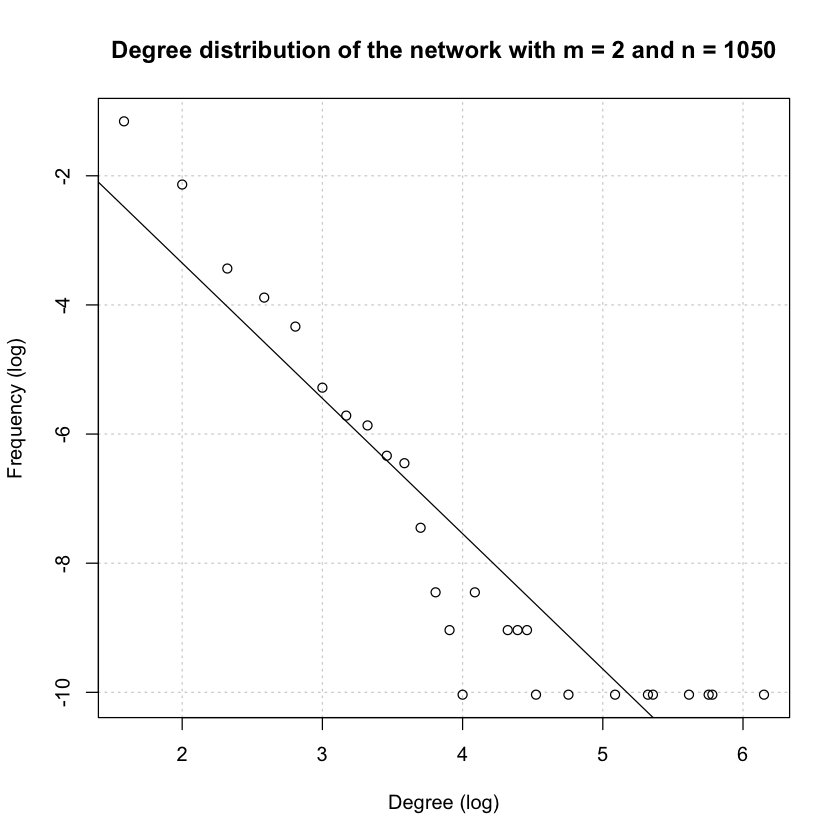

Slope with m = 2 and n = 10500: -2.552

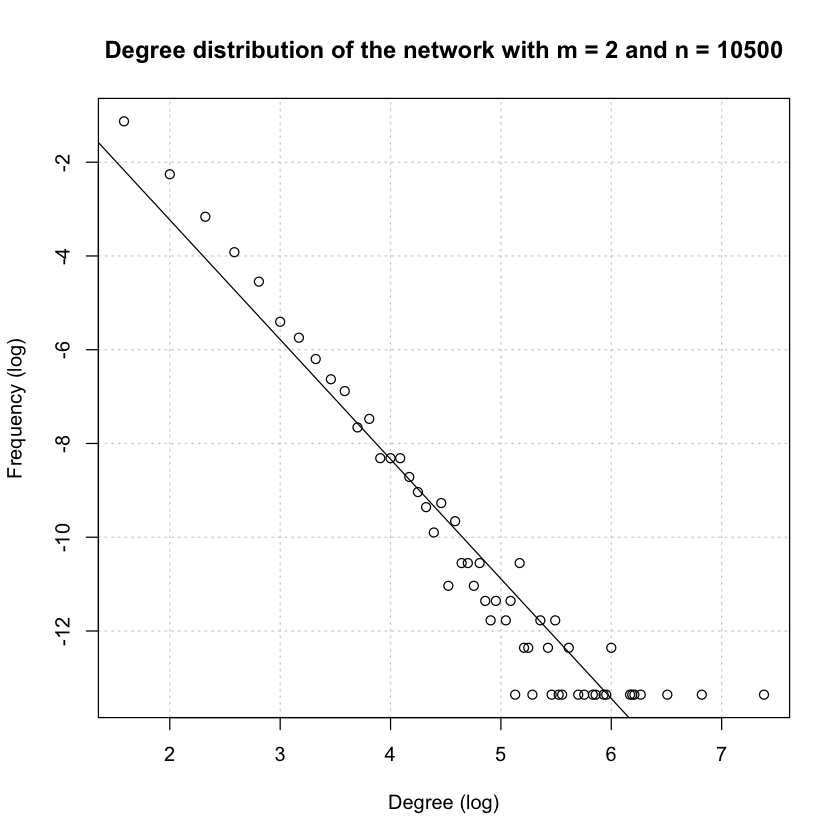

Slope with m = 2 and n = 1050: -1.113

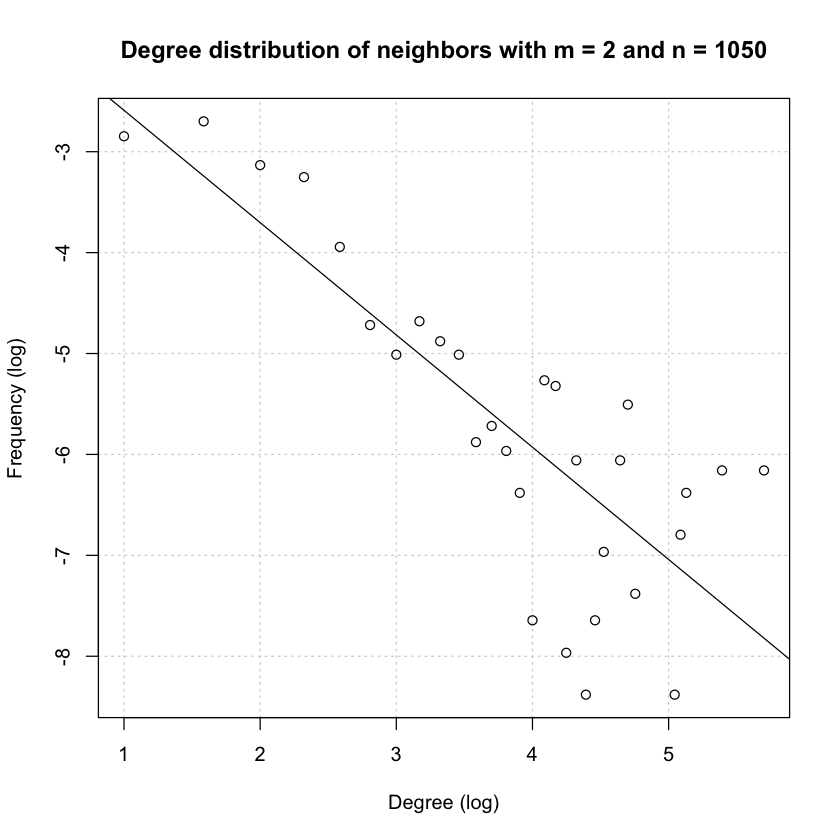

Slope with m = 2 and n = 10500: -1.425

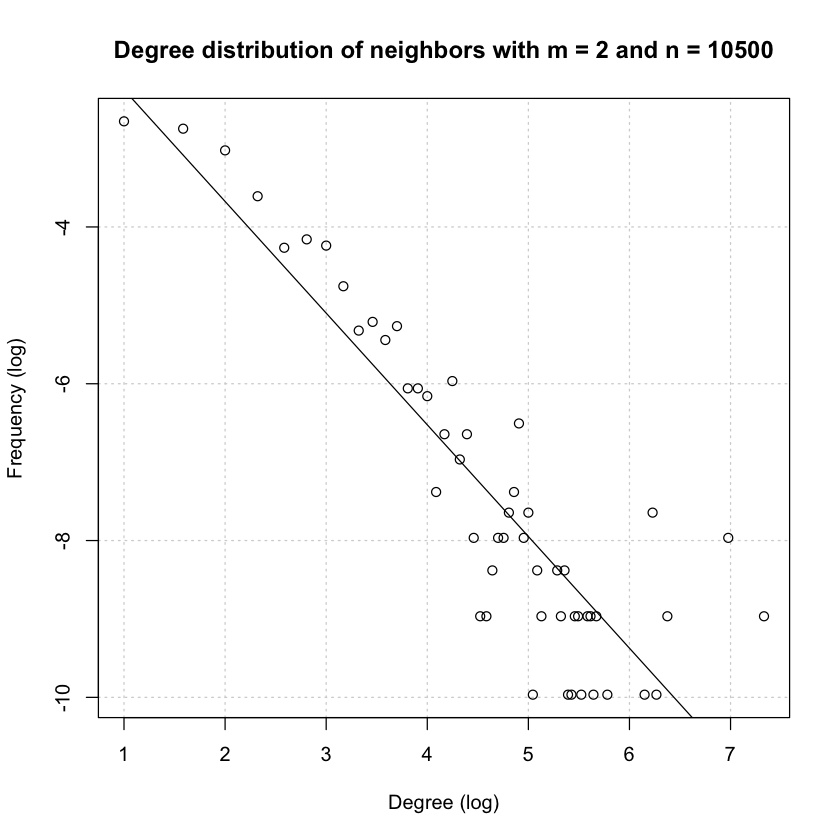

Connected rate with m = 6 and n = 1050: 1.00
m = 6, n = 1050: modularity = 0.252; assortativity = -0.022
m = 6, n = 10500: modularity = 0.245; assortativity = -0.003


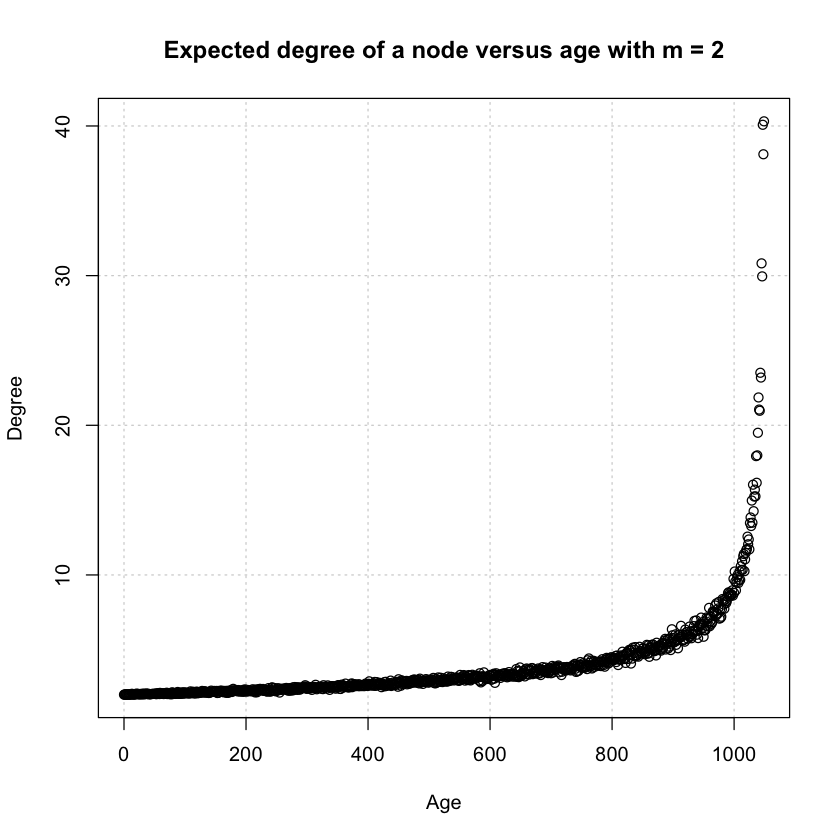

Slope with m = 6 and n = 1050: -2.072

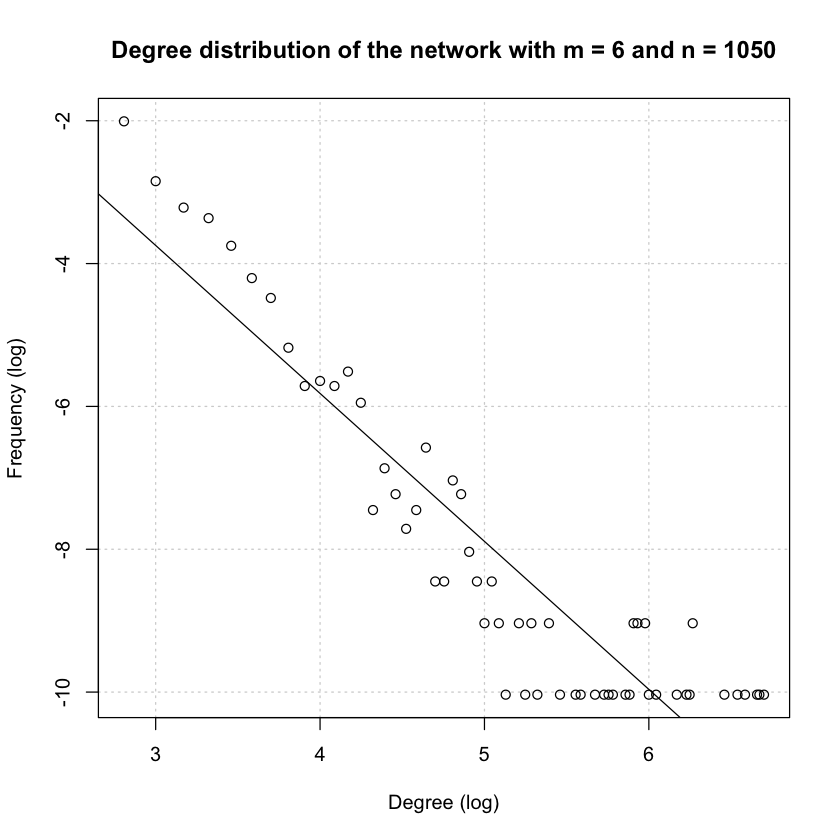

Slope with m = 6 and n = 10500: -2.250

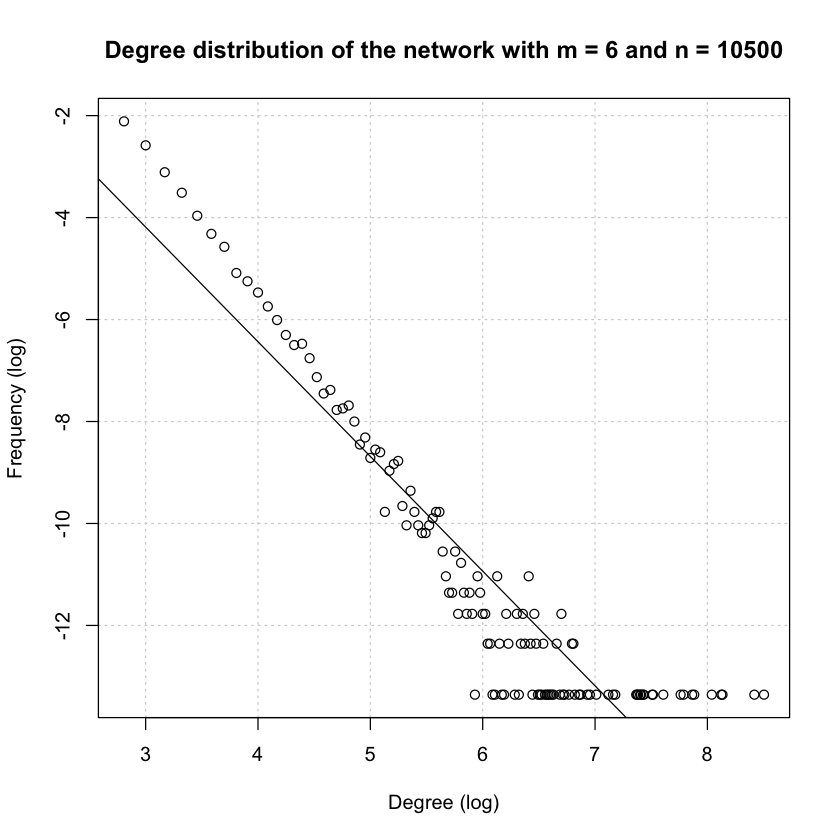

Slope with m = 6 and n = 1050: -0.935

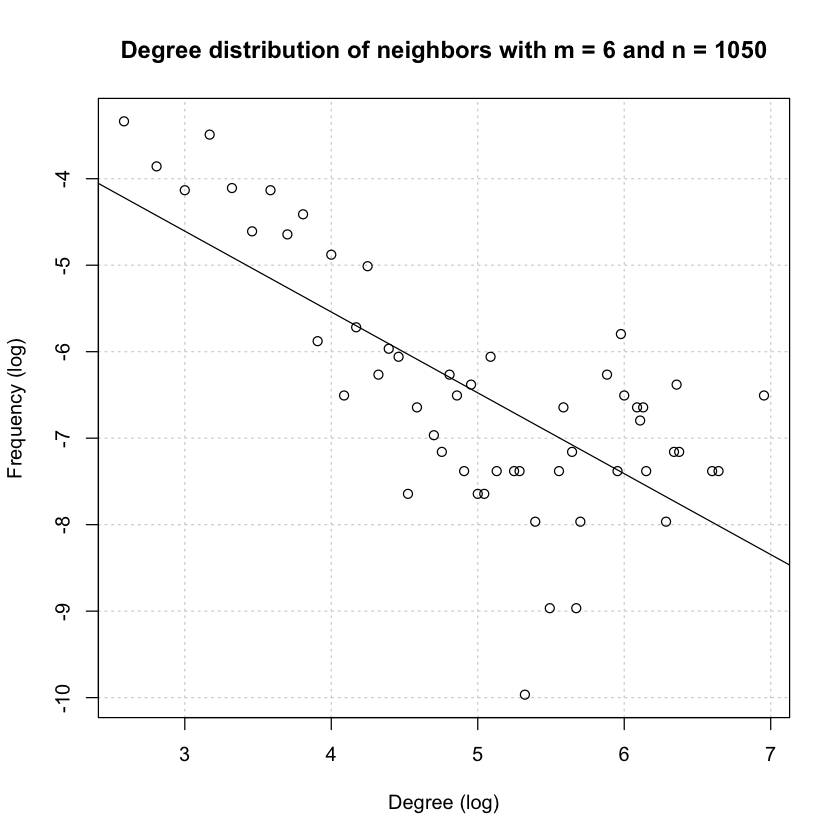

Slope with m = 6 and n = 10500: -1.170

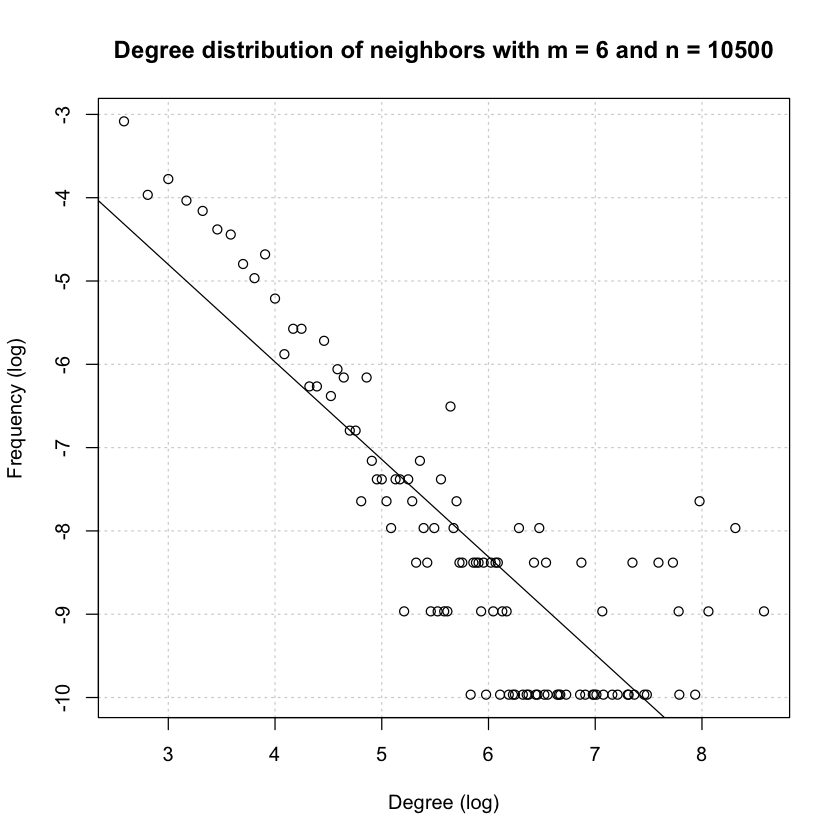

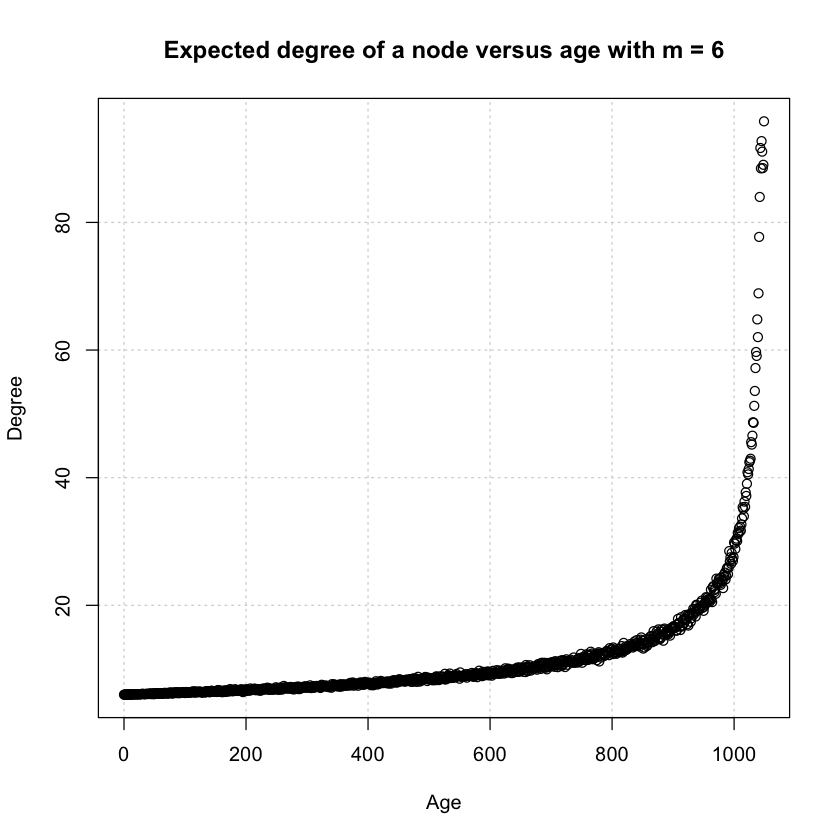

In [15]:
run_preferential_pipeline <- function(m) {
    # a
    check_preferential_connectness(m=m, n=1050)
    # b
    measure_scores(m=m, n=1050)
    # c
    measure_scores(m=m, n=10500)
    # d
    plot_degree_distribution(m=m, n=1050)
    plot_degree_distribution(m=m, n=10500)
    # e
    plot_neighbor_degree_distribution(m=m, n=1050)
    plot_neighbor_degree_distribution(m=m, n=10500)
    # f
    plot_age_degree_relation(m=m)
}


run_preferential_pipeline(m=2)
run_preferential_pipeline(m=6)

#### (h) Again, generate a preferential attachment network with n = 1050, m = 1. Take its degree sequence and create a new network with the same degree sequence, through stub-matching procedure. Plot both networks, mark communities on their plots, and measure their modularity. Compare the two procedures for creating random power-law networks.
+ Hint: In case that fastgreedy community detection fails because of self-loops, you may use “walktrap” community detection.

> Ans: The plots and the modularity scores are shown in the below two cells. To compare the results generated by the two procedures, we firstly found that it is not guaranteed that the graph from the stub-matching procedure will be connected even though it is generated from a connected network. Furthermore, we observed that the modularity score of the graph from the stub-matching procedure is lower. As can be seen in the plot, the generated network has denser inter-module connections, making it have a lower modularity score.

Modularity: 0.934

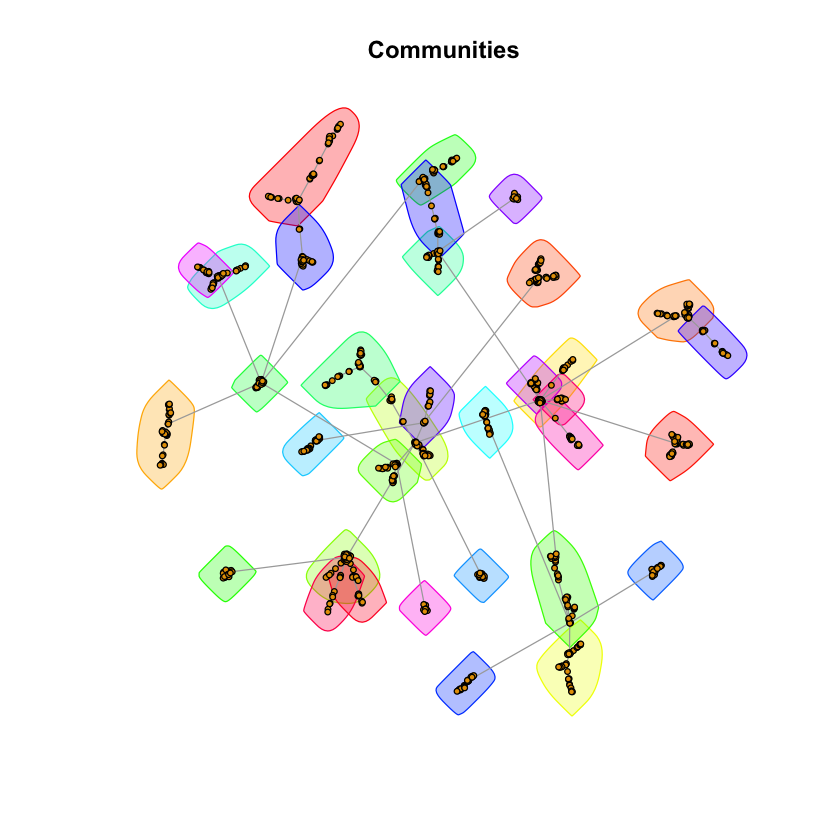

In [16]:
plot_communities <- function(g) {
    communities <- cluster_fast_greedy(g)
    plot(g, mark.groups=groups(communities), vertex.size=2, vertex.label="", main="Communities")
    modularity_score <- modularity(communities)
    fprintf("Modularity: %.3f", modularity_score)
}


g <- barabasi.game(1050, m=1, directed=FALSE)
plot_communities(g)

Modularity: 0.846

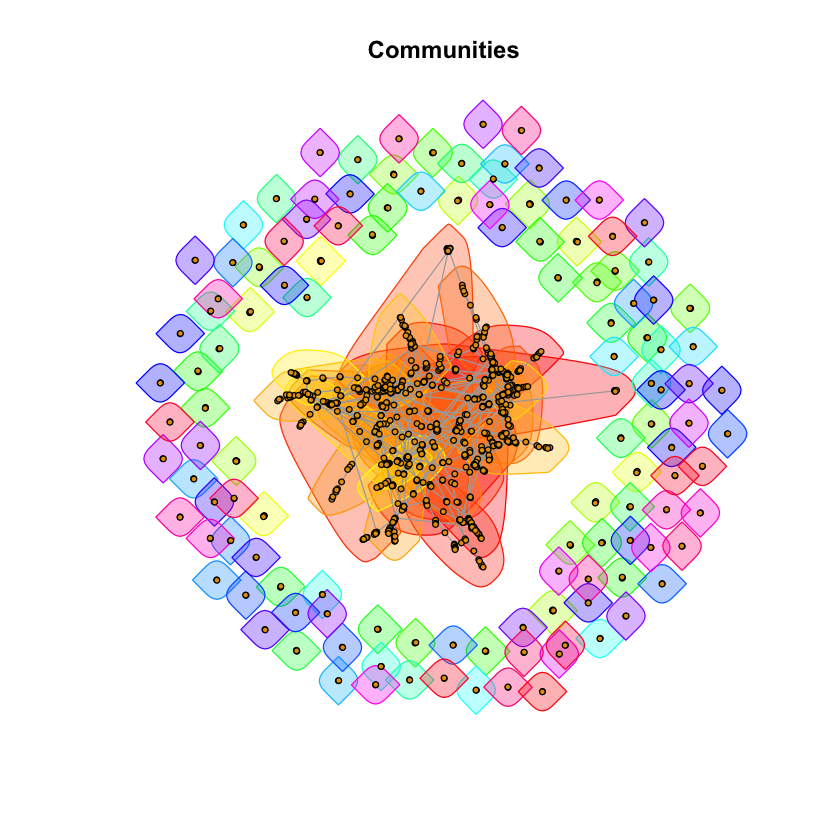

In [17]:
g_new <- sample_degseq(degree(g), method="simple.no.multiple")
plot_communities(g_new)

### 3. Create a modified preferential attachment model that penalizes the age of a node
***

#### (a) Each time a new vertex is added, it creates m links to old vertices and the probability that an old vertex is cited depends on its degree (preferential attachment) and age. In particular, the probability that a newly added vertex connects to an old vertex is proportional to: $P[i]\sim(ck_i^\alpha+a)(dl_i^\beta+b)$, where $k_i$ is the degree of vertex i in the current time step, and $l_i$ is the age of vertex i. Produce such an undirected network with 1050 nodes and parameters m = 1, α = 1, β = −1, and a = c = d = 1, b = 0. Plot the degree distribution. What is the power law exponent?

> Ans: The plot is shown in the below cell and the power law exponent turns out to be 3.682.

Slope with m = 1 and n = 1050: -3.682

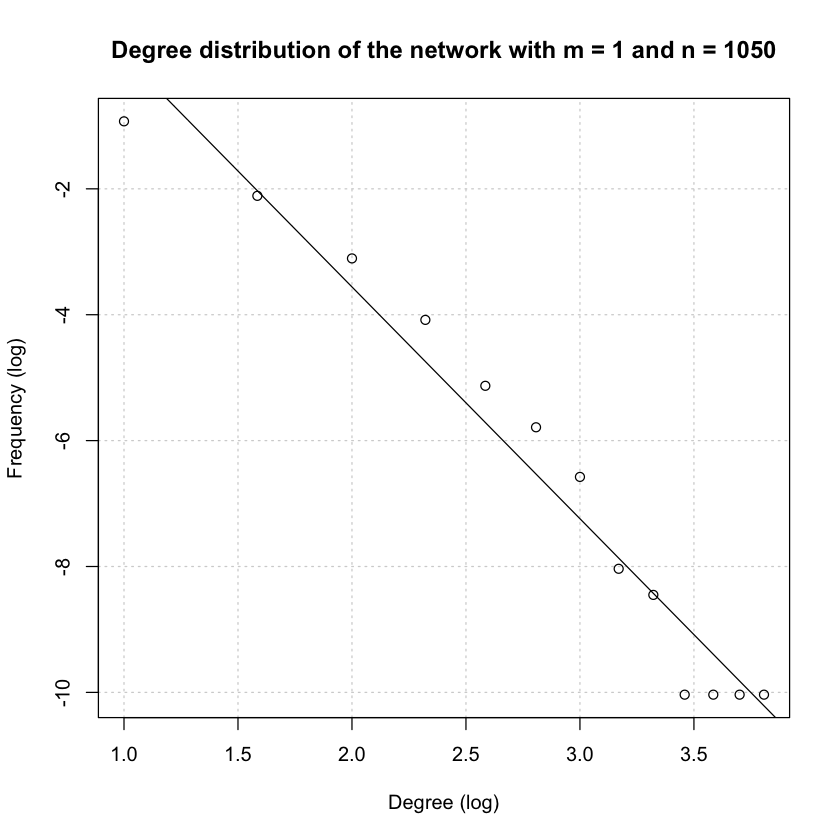

In [18]:
g <- sample_pa_age(
    1050,
    m=1,
    directed=FALSE,
    pa.exp=1,
    aging.exp=-1,
    zero.deg.appeal=1,
    zero.age.appeal=0,
    deg.coef=1,
    age.coef=1,
)
plot_degree_distribution(m=1, n=1050, g=g)

#### (b) Use fast greedy method to find the community structure. What is the modularity?

> Ans: The community structure is shown in the below cell and the modularity is 0.937.

Modularity: 0.937

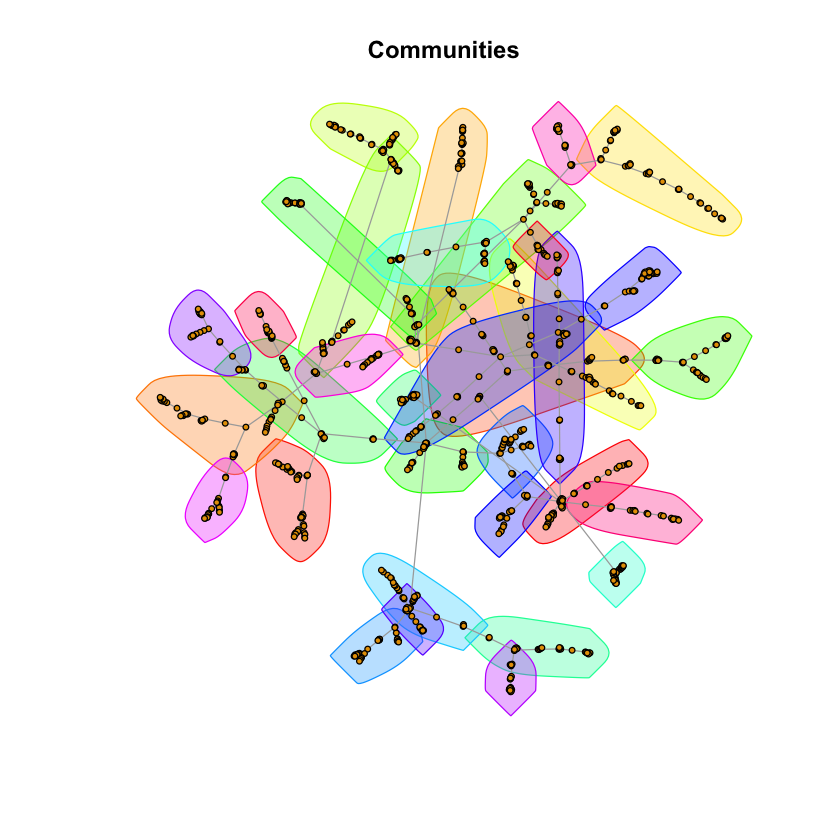

In [19]:
plot_communities(g)